In [1]:
# What samples are in which SJ project? Do we need both?

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

pd.set_option('display.max_columns', None)

In [6]:
si_ppc_ec="SAMPLE_INFO PedPanCancer ecDNA.txt"
si_ppc_cl="SAMPLE_INFO PedPanCan_clinical.txt"

def read_sampleinfo(file):
    df = pd.read_csv(file,sep='\t')
    df=df[(df.sequencing_type=='WGS') & (df.file_type=='BAM') & (df.sample_type!='Germline') & 
          df.file_path.map(lambda x: x.endswith(".bam"))].copy()
    return df
ec = read_sampleinfo(si_ppc_ec)
ec["source"]="ec"
cl = read_sampleinfo(si_ppc_cl)
cl["source"]="cl"

si_ppc_la="SAMPLE_INFO_2022-03-02.tsv"
la = read_sampleinfo(si_ppc_la)
la["source"]="la"

/tmp/ipykernel_21388/68740248.py:5: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file,sep='\t')


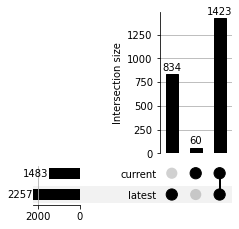

In [7]:
#patient set overlap
def patient_set_overlap():
    a = set(ec.subject_name)
    #b = set(cl.subject_name)
    c = set(la.subject_name)
    dataset = upsetplot.from_contents({
        "current":a,
        #"additional":b,
        "latest":c
    })
    #dataset = upsetplot.UpSet(dataset,subset_size='count')
    upsetplot.plot(dataset, show_counts=True)
    return
patient_set_overlap()
# 1483 patients currently. 
# None in additional that arent in latest
# 834 additional patients in latest.

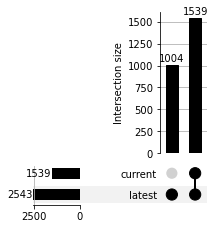

In [8]:
#sample set overlap
def sample_set_overlap():
    a = set(ec.sample_name)
    #b = set(cl.sample_name)
    c = set(la.sample_name)
    dataset = upsetplot.from_contents({
        "current":a,
        #"additional":b,
        "latest":c
    })
    upsetplot.plot(dataset, show_counts=True)
    return
sample_set_overlap()
# 1539 samples currently. 
# None in additional that arent in latest
# 1004 additional samples in latest.

In [9]:
def create_joint_cohort():
    df = pd.concat([ec,la],ignore_index=True)
    df = df.sort_values(by=["sample_name","source"])
    # Latest has more complete metadata than our current.
    df = df.drop_duplicates(subset=["sample_name"],keep='last') # keep the la metadata
    df.loc[df.sample_name.isin(ec.sample_name),"source"]="ec" # but note that it's in our current cohort.
    return df
joint_cohort = create_joint_cohort()
new_cohort = joint_cohort[joint_cohort.source=='la']
current_cohort = joint_cohort[joint_cohort.source=='ec']

,current,latest,Total
sample_type,,,
Diagnosis,1446.0,777,2223.0
Relapse,72.0,88,160.0
Xenograft,0.0,109,109.0
Metastasis,21.0,7,28.0
Autopsy,0.0,23,23.0


<Figure size 432x288 with 0 Axes>

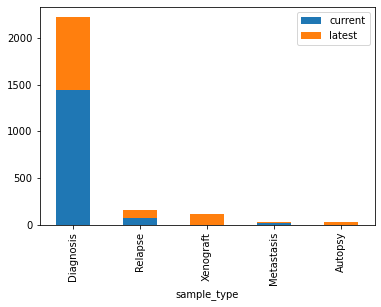

In [10]:
# What kinds of new samples did we get?
def sj_sample_types():
    #print("New cohort by sample type:")
    new_ct = new_cohort.groupby('sample_type').count().sample_name
    new_ct.name = 'latest'
    #print("\nCurrent cohort by sample type:")
    cur_ct = current_cohort.groupby('sample_type').count().sample_name
    cur_ct.name = 'current'
    df = pd.concat([cur_ct,new_ct],axis=1).fillna(0)
    df["Total"] = df.current + df.latest
    df.sort_values("Total",inplace=True,ascending=False)
    # plot
    sns.despine()
    df[["current","latest"]].plot(kind='bar',stacked=True)
    plt.gcf().set_size_inches(6, 4)
    return df
sj_sample_types()

,current,latest,Total
attr_oncotree_disease_code,,,
AML,28.0,149.0,177.0
NBL,109.0,55.0,164.0
BLLHYPER,116.0,23.0,139.0
BLLETV6RUNX1,102.0,28.0,130.0
OS,73.0,56.0,129.0
...,...,...,...
APLPMLRARA,3.0,0.0,3.0
EPIS,0.0,3.0,3.0
GNBL,1.0,2.0,3.0


<Figure size 432x288 with 0 Axes>

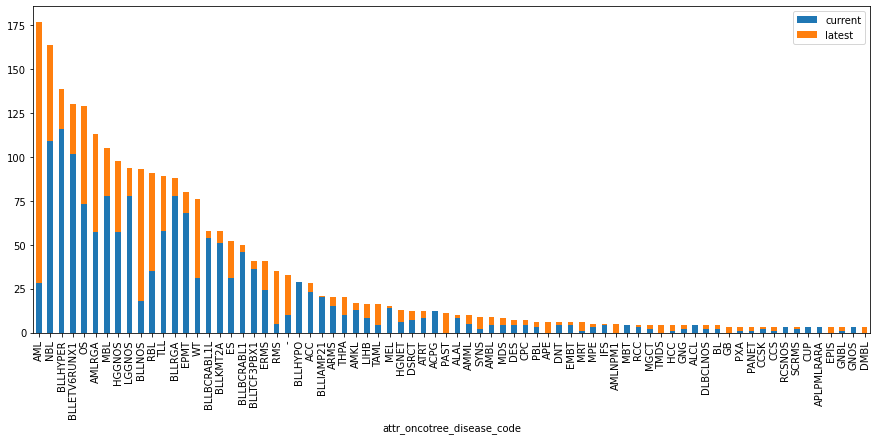

In [11]:
# what tumor types did we get?
def sj_sample_tumor_types():
    #print("New cohort by sample type:")
    new_ct = new_cohort.groupby('attr_oncotree_disease_code').count().sample_name
    new_ct.name = 'latest'
    #print("\nCurrent cohort by sample type:")
    cur_ct = current_cohort.groupby('attr_oncotree_disease_code').count().sample_name
    cur_ct.name = 'current'
    df = pd.concat([cur_ct,new_ct],axis=1).fillna(0)
    df["Total"] = df.current + df.latest
    df.sort_values("Total",inplace=True,ascending=False)
    # drop codes with less than a certain number of counts
    df = df[df.Total > 2]
    # plot
    sns.despine()
    df[["current","latest"]].plot(kind='bar',stacked=True)
    plt.gcf().set_size_inches(15, 6)
    return df

sj_sample_tumor_types()

attr_oncotree_disease_code
RBL      26
OS       22
RMS      18
NBL      13
ES        6
ERMS      5
-         4
WT        4
CCS       2
DSRCT     2
MRT       2
ACC       1
EPIS      1
IFS       1
LIHB      1
LIPO      1
Name: latest, dtype: int64

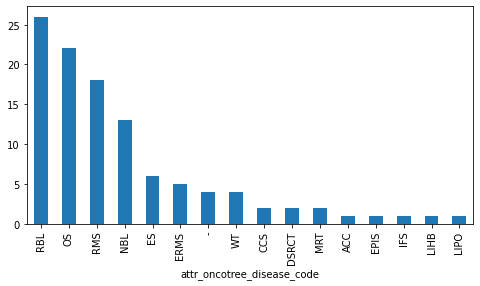

In [12]:
# what xenografts did we get?
def sj_xenograft_tumor_types():
    df = new_cohort[new_cohort.sample_type == 'Xenograft']
    df = df.groupby('attr_oncotree_disease_code').count().sample_name.copy()
    df.name = 'latest'
    df.sort_values(inplace=True,ascending=False)
    # plot
    sns.despine()
    df.plot(kind='bar')
    plt.gcf().set_size_inches(8, 4)
    return df

sj_xenograft_tumor_types()

In [13]:
# What other data do I have for the xenograft tumors?
def sj_xenograft_patient_samples():
    xenograft_patients = set(new_cohort[new_cohort.sample_type == 'Xenograft'].subject_name)
    df = joint_cohort[joint_cohort.subject_name.isin(xenograft_patients)]
    # How many have paired ht data? (Diagnosis, Metastasis, or Relapse)
    print("Xenografts with paired human tumor:")
    subjects_w_human_tumor=df[df.sample_type.isin(["Diagnosis","Metastasis","Relapse"])].subject_name.unique()
    print("{}/{}".format(
        len(df[(df.sample_type=="Xenograft") & (df.subject_name.isin(subjects_w_human_tumor))]),
        len(df[df.sample_type=="Xenograft"]))
    )
    df = df.groupby(["subject_name","sample_type"]).count()
    return df
sj_xenograft_patient_samples()
#joint_cohort[(joint_cohort.subject_name=="SJ000026")]
#joint_cohort[(joint_cohort.subject_name=="SJ000911")]

Xenografts with paired human tumor:
99/109


file_path  sample_name  sequencing_type  file_type  \
subject_name sample_type                                                       
SJ000026     Relapse              4            4                4          4   
             Xenograft            2            2                2          2   
SJ000911     Diagnosis            2            2                2          2   
             Xenograft            2            2                2          2   
SJ000912     Diagnosis            1            1                1          1   
...                             ...          ...              ...        ...   
SJ063840     Xenograft            1            1                1          1   
SJ063841     Diagnosis            1            1                1          1   
             Xenograft            1            1                1          1   
SJ063842     Diagnosis            1            1                1          1   
             Xenograft            1            1                1          1   

                          description  sj_diseases  sj_datasets  \
subject_name sample_type                                          
SJ000026     Relapse                4            4            4   
             Xenograft              2            2            2   
SJ000911     Diagnosis              2            2            2   
             Xenograft              2            2            2   
SJ000912     Diagnosis              1            1            1   
...                               ...          ...          ...   
SJ063840     Xenograft              1            1            1   
SJ063841     Diagnosis              1            1            1   
             Xenograft              1            1            1   
SJ063842     Diagnosis              1            1            1   
             Xenograft              1            1            1   

                          sj_pmid_accessions  sj_ega_accessions  \
subject_name sample_type                                          
SJ000026     Relapse                       4                  4   
             Xenograft                     2                  2   
SJ000911     Diagnosis                     2                  2   
             Xenograft                     2                  2   
SJ000912     Diagnosis                     1                  1   
...                                      ...                ...   
SJ063840     Xenograft                     1                  1   
SJ063841     Diagnosis                     1                  1   
             Xenograft                     1                  1   
SJ063842     Diagnosis                     1                  1   
             Xenograft                     1                  1   

                          attr_ethnicity  attr_oncotree_disease_code  \
subject_name sample_type                                               
SJ000026     Relapse                   4                           4   
             Xenograft                 2                           2   
SJ000911     Diagnosis                 2                           2   
             Xenograft                 2                           2   
SJ000912     Diagnosis                 1                           1   
...                                  ...                         ...   
SJ063840     Xenograft                 1                           1   
SJ063841     Diagnosis                 1                           1   
             Xenograft                 1                           1   
SJ063842     Diagnosis                 1                           1   
             Xenograft                 1                           1   

                          attr_race  attr_sex  sj_dataset_accessions  \
subject_name sample_type                                               
SJ000026     Relapse              4         4                      4   
             Xenograft            2         2                      2   
SJ000911     Dia

In [22]:
# What files does Shanqing need?
def read_germlineinfo(file):
    df = pd.read_csv(file,sep='\t')
    df=df[(df.sequencing_type=='WGS') & (df.file_type=='BAM') & (df.sample_type=='Germline') & 
          df.file_path.map(lambda x: x.endswith(".bam"))].copy()
    return df

def create_latest_file_list():
    file="SAMPLE_INFO_2022-03-02.tsv"
    df = read_germlineinfo(file)
    
    patients = new_cohort.subject_name
    df=df[df.subject_name.isin(patients)]
    print("{} patients with germline sequencing.".format(len(df.drop_duplicates("subject_name"))))
    
    df = pd.concat([df,new_cohort])
    
    # Add .bai files
    bais = df.file_path.map(lambda x: x+".bai").to_list()
    file="SAMPLE_INFO_2022-03-02.tsv"
    bai_files = pd.read_csv(file,sep='\t')
    bai_files = bai_files[bai_files.file_path.isin(bais)]
    print(len(df))
    print(len(bai_files))
    
    df = pd.concat([df,bai_files]).sort_values("sample_name")
    
    return df
sampleinfo = create_latest_file_list()
sampleinfo.to_csv("SAMPLE_INFO_batch_2022-03-03.txt",sep='\t',index=False)
# Why are there multiple germlines for some patients? 
# idk, let's give Shanqing something to think about.

835 patients with germline sequencing.
1873
1875


In [21]:
sampleinfo

,file_path,file_id,subject_name,sample_name,sample_type,sequencing_type,file_type,description,sj_long_disease_name,sj_dataset_accessions,sj_pmid_accessions,sj_publication_titles,sj_diseases,sj_datasets,sj_pub_accessions,sj_ega_accessions,sj_embargo_date,attr_age_at_diagnosis,attr_diagnosis,attr_sex,attr_ethnicity,attr_race,sj_genome_build,attr_oncotree_disease_code,sj_pipeline_name,sj_pipeline_version,attr_library_selection_protocol,attr_read_length,attr_sequencing_platform,attr_read_type,attr_diagnosis_group,attr_tissue_preservative,attr_inferred_strandedness,attr_lab_strandedness,attr_subtype_biomarkers,sj_associated_diagnoses,sj_associated_diagnoses_disease_code,attr_germline_sample,source
3285,/restricted/BAM/SJACT013760_D1.WholeGenome.bam,file-FkjVBfQ9K0QPxXjB37862gKY,SJ013760,SJACT013760_D1,Diagnosis,WGS,BAM,-,Adrenocortical Carcinoma,SJC-DS-1008,-,-,ACC,Childhood Solid Tumor Network (CSTN),-,-,Dec-12-2020,Not Available,Not Available,Not Available,Not Available,Not Available,-,ACC,DNA-Seq Standard,1.0.0,Not Available,Not Available,Not Available,Not Available,Solid Tumor,Not Available,Not Applicable,Not Applicable,Not Available,Adrenocortical Carcinoma (ACC),ACC,-,la
68598,/restricted/BAM/SJACT013760_D1.WholeGenome.bam...,file-FkjVBj09K0Q7fGJkF62VYj8P,SJ013760,SJACT013760_D1,Diagnosis,WGS,BAM,-,Adrenocortical Carcinoma,SJC-DS-1008,-,-,ACC,Childhood Solid Tumor Network (CSTN),-,-,Dec-12-2020,Not Available,Not Available,Not Available,Not Available,Not Available,-,ACC,DNA-Seq Standard,1.0.0,Not Available,Not Available,Not Available,Not Available,Solid Tumor,Not Available,Not Applicable,Not Applicable,Not Available,Adrenocortical Carcinoma (ACC),ACC,-,NaN
68649,/restricted/BAM/SJACT013760_G1.WholeGenome.bam,file-FkjV3vQ9K0QKk5qB823fyjZB,SJ013760,SJACT013760_G1,Germline,WGS,BAM,-,-,SJC-DS-1008,-,-,-,Childhood Solid Tumor Network (CSTN),-,-,Dec-12-2020,Not Available,Not Available,Not Available,Not Available,Not Available,-,ACC,DNA-Seq Standard,1.0.0,Not Available,Not Available,Not Available,Not Available,Solid Tumor,Not Available,Not Applicable,Not Applicable,Not Applicable,Adrenocortical Carcinoma (ACC),ACC,-,NaN
68645,/restricted/BAM/SJACT013760_G1.WholeGenome.bam...,file-FkjV3y09K0Q381k5FxQ0xZJ1,SJ013760,SJACT013760_G1,Germline,WGS,BAM,-,-,SJC-DS-1008,-,-,-,Childhood Solid Tumor Network (CSTN),-,-,Dec-12-2020,Not Available,Not Available,Not Available,Not Available,Not Available,-,ACC,DNA-Seq Standard,1.0.0,Not Available,Not Available,Not Available,Not Available,Solid Tumor,Not Available,Not Applicable,Not Applicable,Not Applicable,Adrenocortical Carcinoma (ACC),ACC,-,NaN
68590,/restricted/BAM/SJACT013760_X1.WholeGenome.bam...,file-FkjV7Pj9K0Q6KjjvFyb5434K,SJ013760,SJACT013760_X1,Xenograft,WGS,BAM,-,Adrenocortical Carcinoma,SJC-DS-1008,-,-,ACC,Childhood Solid Tumor Network (CSTN),-,-,Dec-12-2020,Not Available,Not Available,Not Available,Not Available,Not Available,-,ACC,DNA-Seq Standard,1.0.0,Not Available,Not Available,Not Available,Not Available,Solid Tumor,Not Available,Not Applicable,Not Applicable,Not Available,Adrenocortical Carcinoma (ACC),ACC,-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89574,/restricted/BAM/SJWLM046158_G1.WholeGenome.bam,file-G2zJjxj9K0Q3bxF0GPk0BZ9J,SJ046158,SJWLM046158_G1,Germline,WGS,BAM,-,-,SJC-DS-1008,-,-,-,Childhood Solid Tumor Network (CSTN),-,-,Jun-01-2021,6.00,Not Available,Female,Not Available,Not Available,-,WT,DNA-Seq Standard,1.0.0,Not Available,151,HiSeq X,Paired-end,Solid Tumor,Fresh/Frozen,Not Applicable,Not Applicable,Not Applicable,Wilms (WT),WT,-,NaN
89572,/restricted/BAM/SJWLM046158_X1.WholeGenome.bam...,file-G2zKBJ89K0Q63P4V0jFky2ZY,SJ046158,SJWLM046158_X1,Xenograft,WGS,BAM,-,Wilms,SJC-DS-1008,-,-,WT,Childhood Solid Tumor Network (CSTN),-,-,Jun-01-2021,6.00,Wilms tumor,Female,Not Available,Not Available,-,WT,DNA-Seq Standard,1.0.0,Not Available,151,Hiseq X,Pair

In [3]:
file="SAMPLE_INFO_2022-03-02.tsv"
df = pd.read_csv(file,sep='\t')